# Import the relevant libraries

In [1]:
import os
import io
import cv2
import random
import requests
import numpy as np
from PIL import Image
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing import image as keras_image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the dataset

In [3]:
DIR = "/content/drive/MyDrive/dataset/tebak_sampah_dataset"

In [4]:
def check_image_types(directory):
    invalid_files = []
    print("Checking image types in the dataset...\n")

    # Iterasi melalui setiap subdirektori
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Periksa jika subdirektori
            print(f"Class '{class_name}':")
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # Verifikasi gambar
                        img_type = img.format  # Ambil format gambar
                        print(f"  - {filename}: {img_type}")
                except Exception as e:
                    # Jika file tidak valid atau bukan gambar
                    print(f"  - {filename}: INVALID ({e})")
                    invalid_files.append(file_path)
            print()

    # Hasil file yang invalid
    if invalid_files:
        print("\nInvalid or corrupted files found:")
        for file_path in invalid_files:
            print(f"  - {file_path}")
    else:
        print("\nAll files are valid images.")

# Jalankan fungsi untuk memeriksa tipe gambar
check_image_types(DIR)

Streaming output truncated to the last 5000 lines.
  - green-glass146.jpg: JPEG
  - green-glass149.jpg: JPEG
  - green-glass109.jpg: JPEG
  - green-glass142.jpg: JPEG
  - green-glass126.jpg: JPEG
  - green-glass13.jpg: JPEG
  - green-glass122.jpg: JPEG
  - green-glass111.jpg: JPEG
  - green-glass116.jpg: JPEG
  - green-glass127.jpg: JPEG
  - green-glass163.jpg: JPEG
  - green-glass115.jpg: JPEG
  - green-glass151.jpg: JPEG
  - green-glass125.jpg: JPEG
  - green-glass119.jpg: JPEG
  - green-glass153.jpg: JPEG
  - green-glass140.jpg: JPEG
  - green-glass137.jpg: JPEG
  - green-glass162.jpg: JPEG
  - green-glass123.jpg: JPEG
  - green-glass167.jpg: JPEG
  - green-glass131.jpg: JPEG
  - green-glass173.jpg: JPEG
  - green-glass113.jpg: JPEG
  - green-glass168.jpg: JPEG
  - green-glass16.jpg: JPEG
  - green-glass117.jpg: JPEG
  - green-glass136.jpg: JPEG
  - green-glass102.jpg: JPEG
  - green-glass101.jpg: JPEG
  - green-glass139.jpg: JPEG
  - green-glass108.jpg: JPEG
  - green-glass1.jpg: J

### Splitting Dataset

In [5]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    batch_size=32,
    image_size=(256, 256)
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size=32,
    image_size=(256, 256)
)

Found 7377 files belonging to 18 classes.
Using 5902 files for training.
Found 7377 files belonging to 18 classes.
Using 1475 files for validation.


### Describing Dataset

In [6]:
def count_files_per_class(directory):
    class_counts = {}

    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            class_counts[class_name] = len(files)

    return class_counts

file_counts = count_files_per_class(DIR)

for class_name, count in file_counts.items():
    print(f"Class '{class_name}' memiliki {count} file")

Class 'brown-glass' memiliki 405 file
Class 'cigarettes_butts' memiliki 400 file
Class 'foods' memiliki 437 file
Class 'cardboard' memiliki 403 file
Class 'metal' memiliki 411 file
Class 'green-glass' memiliki 403 file
Class 'e-waste' memiliki 406 file
Class 'footwear' memiliki 403 file
Class 'clothings' memiliki 402 file
Class 'hazard' memiliki 414 file
Class 'rubber' memiliki 409 file
Class 'miscellaneous_trash' memiliki 410 file
Class 'paper' memiliki 413 file
Class 'plastic' memiliki 406 file
Class 'white-glass' memiliki 413 file
Class 'wheel' memiliki 406 file
Class 'styrofoam' memiliki 400 file
Class 'vegetation' memiliki 436 file


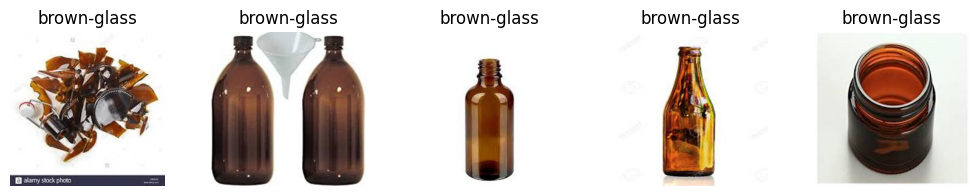

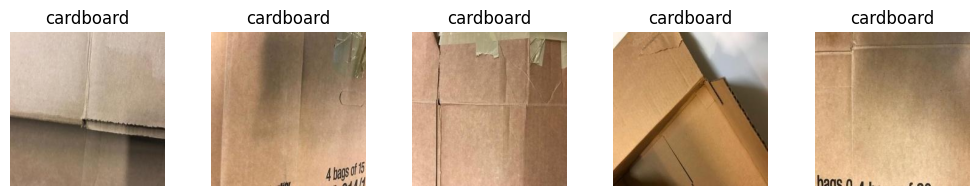

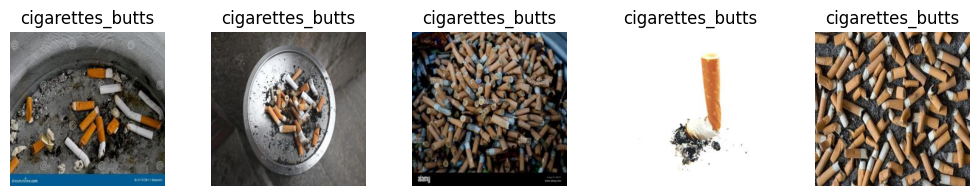

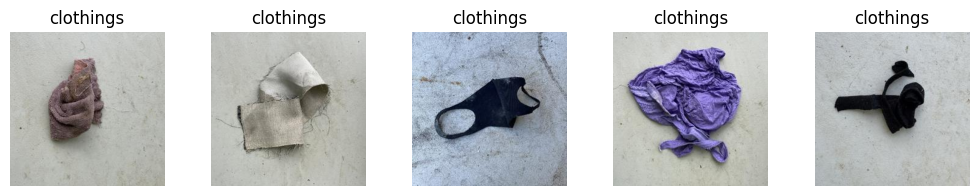

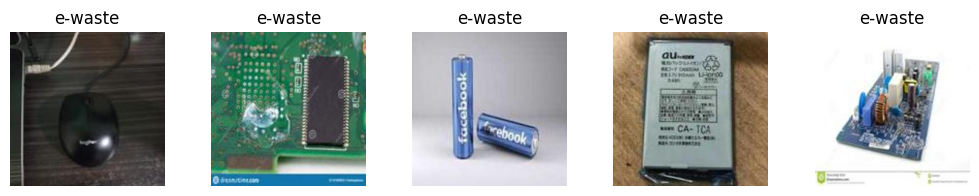

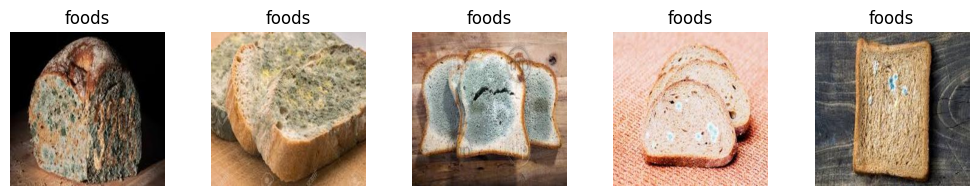

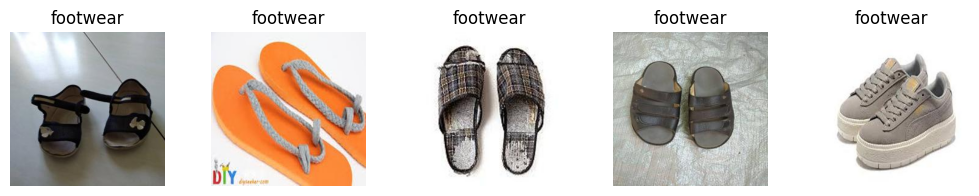

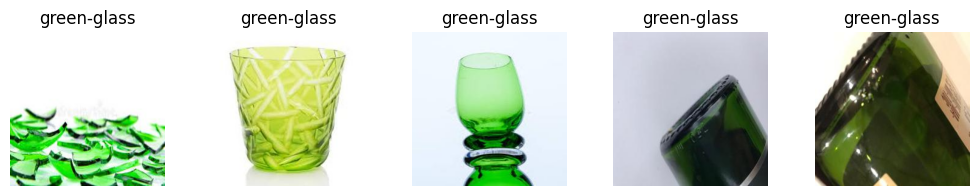

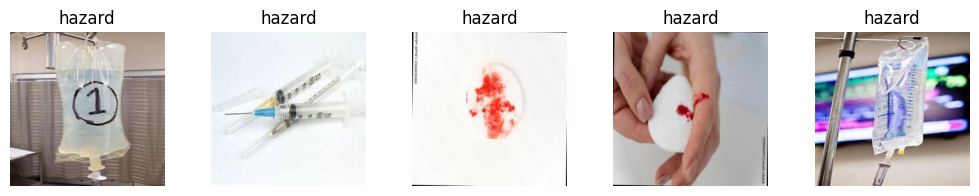

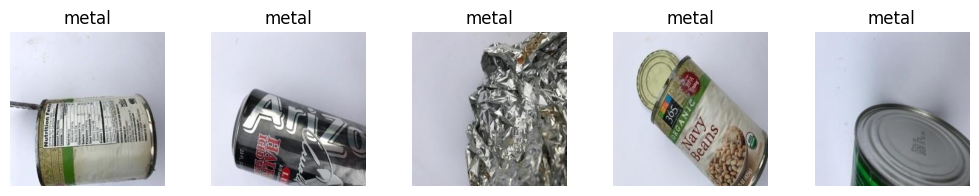

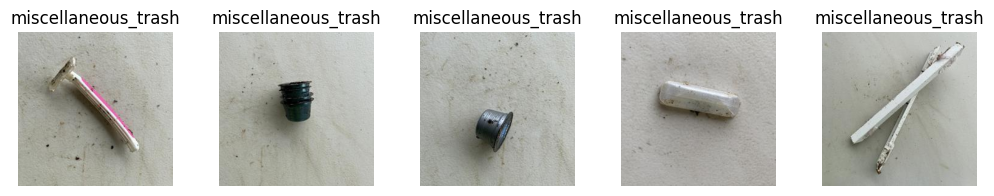

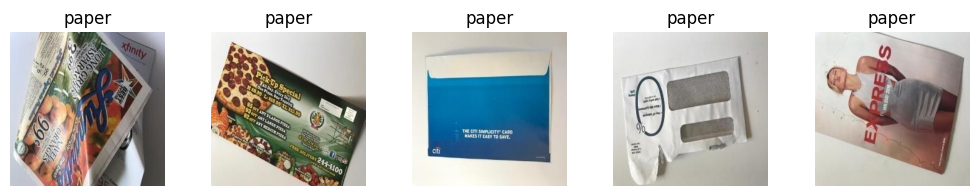

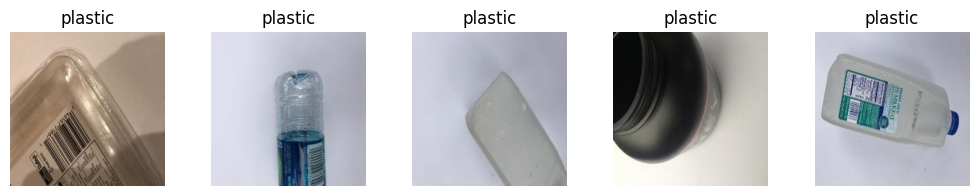

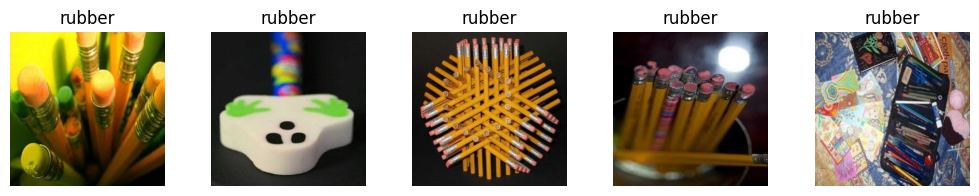

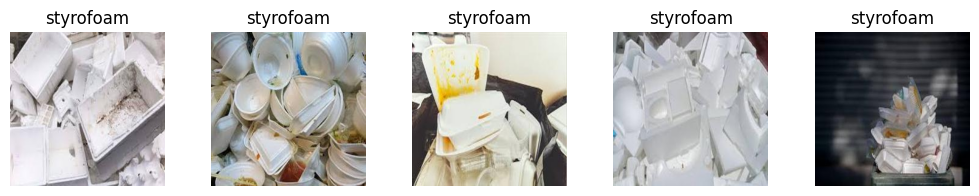

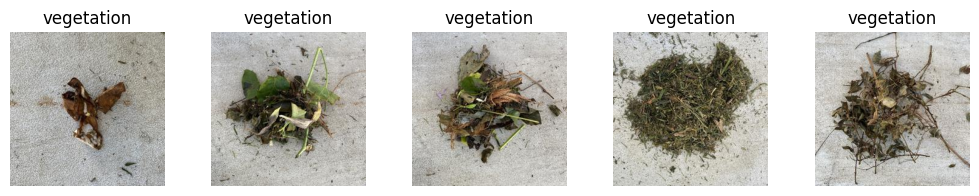

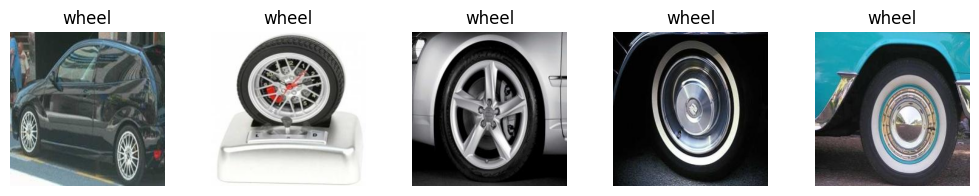

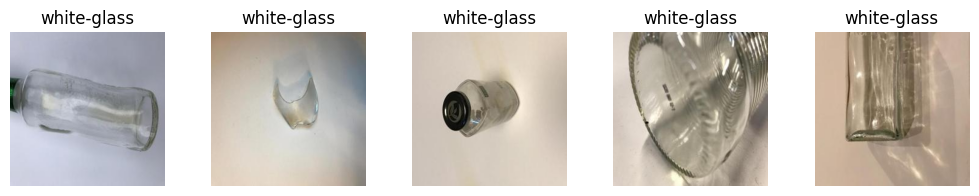

In [7]:
def plot_imgs(DIR, top=10):
    all_DIRs = os.listdir(DIR)
    item_files = [os.path.join(DIR, file) for file in all_DIRs][:5]

    plt.figure(figsize=(10, 10)) #pyplot

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(DIR))

plot_imgs(DIR+'/brown-glass')
plot_imgs(DIR+'/cardboard')
plot_imgs(DIR+'/cigarettes_butts')
plot_imgs(DIR+'/clothings')
plot_imgs(DIR+'/e-waste')
plot_imgs(DIR+'/foods')
plot_imgs(DIR+'/footwear')
plot_imgs(DIR+'/green-glass')
plot_imgs(DIR+'/hazard')
plot_imgs(DIR+'/metal')
plot_imgs(DIR+'/miscellaneous_trash')
plot_imgs(DIR+'/paper')
plot_imgs(DIR+'/plastic')
plot_imgs(DIR+'/rubber')
plot_imgs(DIR+'/styrofoam')
plot_imgs(DIR+'/vegetation')
plot_imgs(DIR+'/wheel')
plot_imgs(DIR+'/white-glass')

In [8]:
def plot_imgs(DIR, top=1):
    all_item_files = os.listdir(DIR)[:top]

    for idx, file in enumerate(all_item_files):
        img_path = os.path.join(DIR, file)
        img = cv2.imread(img_path)

        if img is not None:
            height, width = img.shape[:2]  # Mengambil dimensi gambar
            print(f"Image: {file}, Resolution: {width} x {height}")

plot_imgs(DIR)

plot_imgs(DIR+'/brown-glass')
plot_imgs(DIR+'/cardboard')
plot_imgs(DIR+'/cigarettes_butts')
plot_imgs(DIR+'/clothings')
plot_imgs(DIR+'/e-waste')
plot_imgs(DIR+'/foods')
plot_imgs(DIR+'/footwear')
plot_imgs(DIR+'/green-glass')
plot_imgs(DIR+'/hazard')
plot_imgs(DIR+'/metal')
plot_imgs(DIR+'/miscellaneous_trash')
plot_imgs(DIR+'/paper')
plot_imgs(DIR+'/plastic')
plot_imgs(DIR+'/rubber')
plot_imgs(DIR+'/styrofoam')
plot_imgs(DIR+'/vegetation')
plot_imgs(DIR+'/wheel')
plot_imgs(DIR+'/white-glass')

Image: brown-glass9.jpg, Resolution: 255 x 255
Image: cardboard_389.jpg, Resolution: 255 x 255
Image: dd2e352f-2cfb-4527-bd22-d0f2f87858bc_jpg.rf.dd4c41aeb87e5616bddd33a67429a823.jpg, Resolution: 255 x 255
Image: Textile Trash_306.jpg, Resolution: 255 x 255
Image: Mouse_16.jpg, Resolution: 255 x 255
Image: biological97.jpg, Resolution: 255 x 255
Image: shoes1776.jpg, Resolution: 255 x 255
Image: green-glass78.jpg, Resolution: 255 x 255
Image: 93_jpg.rf.ce7396347240e8c8253dfcb33fce1f3f.jpg, Resolution: 255 x 255
Image: metal_402.jpg, Resolution: 255 x 255
Image: Miscellaneous Trash_85.jpg, Resolution: 255 x 255
Image: paper_412.jpg, Resolution: 255 x 255
Image: plastic_393.jpg, Resolution: 255 x 255
Image: 06INEPFW7F73.jpg, Resolution: 255 x 255
Image: download (11).jpg, Resolution: 255 x 255
Image: Vegetation_70.jpg, Resolution: 255 x 255
Image: 68D2117KJJGK.jpg, Resolution: 255 x 255
Image: white-glass88.jpg, Resolution: 255 x 255


# Pre-processing

In [9]:
classes = train_dataset.class_names
numClasses = len(train_dataset.class_names)
print(classes, numClasses)

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

['brown-glass', 'cardboard', 'cigarettes_butts', 'clothings', 'e-waste', 'foods', 'footwear', 'green-glass', 'hazard', 'metal', 'miscellaneous_trash', 'paper', 'plastic', 'rubber', 'styrofoam', 'vegetation', 'wheel', 'white-glass'] 18


In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
])

preprocess_input = tf.keras.applications.inception_v3.preprocess_input
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# MODELS

### Create Model

In [12]:
baseModel = tf.keras.applications.ResNet152(input_shape=(256, 256, 3), weights='imagenet',
                                           include_top=False, classes=numClasses)

for layers in baseModel.layers:
    layers.trainable=False

last_output = baseModel.layers[-1].output

x = tf.keras.layers.Dropout(0.5)(last_output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(numClasses, activation='softmax')(x)

model = tf.keras.Model(inputs=baseModel.input, outputs=x)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

### Training Model

In [13]:
epochs=5
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=epochs)

Epoch 1/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 107s 434ms/step - accuracy: 0.4847 - loss: 1.9654 - val_accuracy: 0.8278 - val_loss: 0.5788
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 67s 364ms/step - accuracy: 0.9167 - loss: 0.2602 - val_accuracy: 0.8495 - val_loss: 0.5721
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 73s 315ms/step - accuracy: 0.9720 - loss: 0.0885 - val_accuracy: 0.8732 - val_loss: 0.5535
Epoch 4/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 82s 315ms/step - accuracy: 0.9875 - loss: 0.0505 - val_accuracy: 0.8732 - val_loss: 0.5219
Epoch 5/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 91s 364ms/step - accuracy: 0.9926 - loss: 0.0273 - val_accuracy: 0.8834 - val_loss: 0.5371


# Evaluation

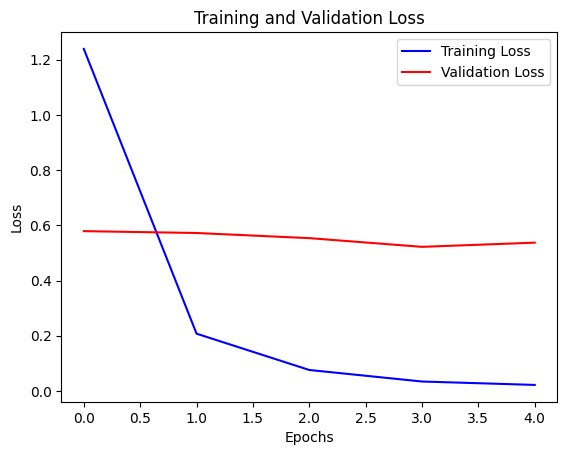

In [14]:
epochs = range(len(history.history["loss"]))

plt.plot(epochs, history.history["loss"], color="b", label="Training Loss")
plt.plot(epochs, history.history["val_loss"], color="r", label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()


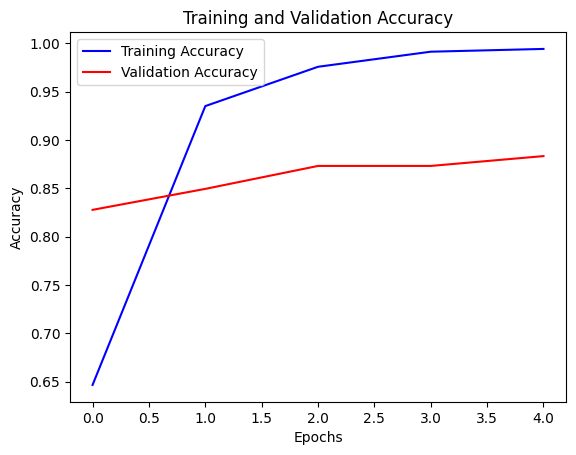

In [15]:
epochs = range(len(history.history["accuracy"]))

plt.plot(epochs, history.history["accuracy"], color="b", label="Training Accuracy")
plt.plot(epochs, history.history["val_accuracy"], color="r", label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.show()


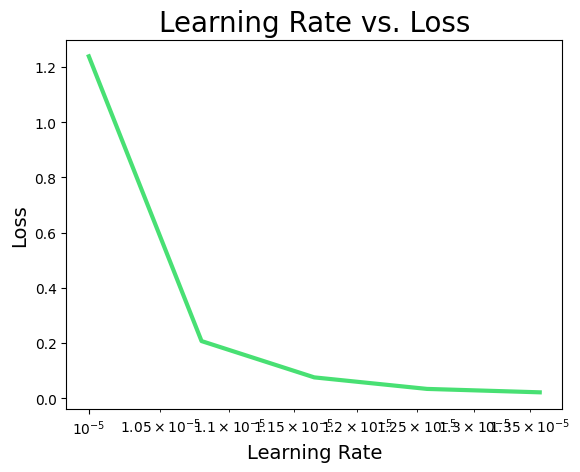

In [16]:
import numpy as np
import matplotlib.pyplot as plt

learning_rates = 1e-5 * (10 ** (np.arange(len(history.history['loss'])) / 30))

plt.plot(learning_rates, history.history
['loss'], lw=3, color='#48e073')
plt.xscale('log')
plt.title('Learning Rate vs. Loss', size=20)
plt.xlabel('Learning Rate', size=14)
plt.ylabel('Loss', size=14)
plt.show()


# Testing

### Dataset Testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
[9.8253018e-04 2.8269098e-03 1.6626995e-03 5.3267297e-09 9.9956924e+01
 2.2111110e-06 4.0548461e-08 3.9449625e-04 1.7889978e-02 1.0925587e-05
 1.0283980e-05 1.8964492e-02 3.6112631e-06 3.2349891e-04 8.5362745e-07
 3.6052052e-07 1.1717053e-05 2.0452203e-06] 
 ['brown-glass', 'cardboard', 'cigarettes_butts', 'clothings', 'e-waste', 'foods', 'footwear', 'green-glass', 'hazard', 'metal', 'miscellaneous_trash', 'paper', 'plastic', 'rubber', 'styrofoam', 'vegetation', 'wheel', 'white-glass']
Prediction:  e-waste 99.95692372322083%


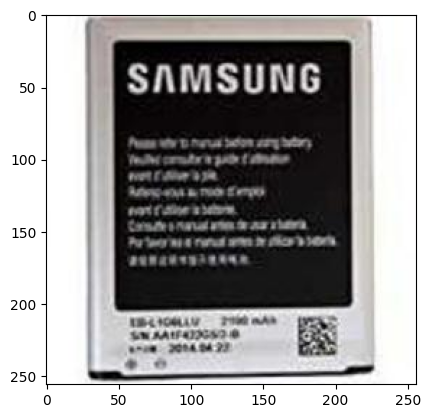

In [17]:
url = '/content/drive/MyDrive/dataset/tebak_sampah_dataset'
image = tf.keras.utils.get_file("/content/drive/MyDrive/dataset/tebak_sampah_dataset/e-waste/battery_0.jpg", origin=url)

img = tf.keras.preprocessing.image.load_img(image, target_size=(256, 256))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)

plt.imshow(img)

print(predictions[0]*100, "\n", classes)
print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")

### URL Testing


In [18]:
image_url = 'https://mycoffeeshop.com.au/cdn/shop/products/Duralex-Provence-latte-glass_1200x.png?v=1672098259'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


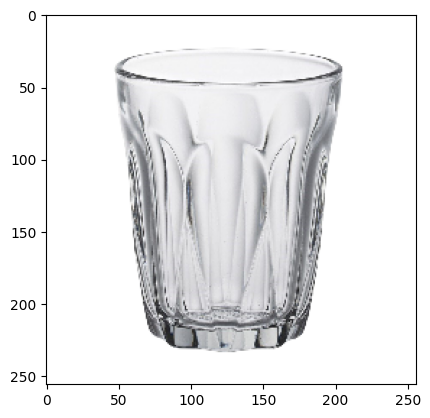

[3.0572191e-04 3.2931183e-08 1.1435000e-08 2.9728099e-04 2.0350574e-06
 2.5308398e-06 2.6993896e-09 3.1313306e-04 1.6671764e-03 4.4732852e-07
 1.0899793e-07 2.1292905e-07 1.5798371e-06 3.5887765e-10 2.5761578e-06
 8.5491381e-10 4.7030131e-09 9.9997398e+01] 
 ['brown-glass', 'cardboard', 'cigarettes_butts', 'clothings', 'e-waste', 'foods', 'footwear', 'green-glass', 'hazard', 'metal', 'miscellaneous_trash', 'paper', 'plastic', 'rubber', 'styrofoam', 'vegetation', 'wheel', 'white-glass']
Prediction:  white-glass 99.9974012374878%


In [19]:
def load_image_from_url(url, target_size=(256, 256)):
    session = requests.Session()
    retry = Retry(connect=5, backoff_factor=1)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)

    headers = {'User-Agent': 'Mozilla/5.0'}

    img_response = session.get(url, headers=headers)
    img_response.raise_for_status()

    img_bytes = io.BytesIO(img_response.content)
    img = keras_image.load_img(img_bytes, target_size=target_size)
    img_array = keras_image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    return img_array, img


try:
    img_array, img = load_image_from_url(image_url)
    predictions = model.predict(img_array)
    plt.imshow(img)
    plt.show()
    print(predictions[0] * 100, "\n", classes)
    print("Prediction: ", classes[np.argmax(predictions)], f"{predictions[0][np.argmax(predictions)]*100}%")
except requests.exceptions.RequestException as e:
    print(f"Error fetching the image: {e}")

In [21]:
model.save('model.h5')